# 1. Problem definition
Electricity demand forecasting has been a real challenge for power system
scheduling in different levels of energy sectors. Short-Term load forecasting (STLF) is
an integral part of the energy planning sector. Designing a time-ahead power market
requires demand-scheduling for various energy divisions, namely, generation,
transmission, and distribution. STLF is particularly essential for the time-ahead power
market operation, inaccurate demand forecasting will cost the utility a tremendous
financial burden.

# 2. Data Reading, Cleaning and Features Generation
we generated two features here to be able to better predict the behaviour of the data, we added a feature for holidays and another for season based on the date

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import random
import calendar

In [2]:
#Importing data
data = pd.read_csv('Load_history.csv')
temp_data=pd.read_csv('temperature_history.csv').dropna()
holidays=pd.read_excel('holidays.xlsx')

In [3]:
#Adding holidays
holidays['weekends'] = holidays[['year', 'month', 'day']].apply(lambda x: 1 if (calendar.weekday(x[0], x[1], x[2]) == 5 or calendar.weekday(x[0], x[1], x[2]) == 6) else 0, axis=1)
holidays['holiday'] = holidays[['isholiday', 'weekends']].apply(lambda x: x[0] or x[1] ,axis=1)


In [4]:
data.head()

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,"16,853","16,450","16,517","16,873","17,064","17,727",...,"13,518","13,138","14,130","16,809","18,150","18,235","17,925","16,904","16,162","14,750"
1,1,2004,1,2,"14,155","14,038","14,019","14,489","14,920","16,072",...,"16,127","15,448","15,839","17,727","18,895","18,650","18,443","17,580","16,467","15,258"
2,1,2004,1,3,"14,439","14,272","14,109","14,081","14,775","15,491",...,"13,507","13,414","13,826","15,825","16,996","16,394","15,406","14,278","13,315","12,424"
3,1,2004,1,4,"11,273","10,415","9,943","9,859","9,881","10,248",...,"14,207","13,614","14,162","16,237","17,430","17,218","16,633","15,238","13,580","11,727"
4,1,2004,1,5,"10,750","10,321","10,107","10,065","10,419","12,101",...,"13,845","14,350","15,501","17,307","18,786","19,089","19,192","18,416","17,006","16,018"


In [5]:
hourly_data=data.iloc[:,4:]

In [6]:
temp_data.head()

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,46,46,45,41,39,35,...,55.0,55.0,52.0,46.0,40.0,40.0,39.0,38.0,40.0,41.0
1,1,2004,1,2,43,44,46,46,47,47,...,54.0,56.0,57.0,53.0,50.0,47.0,46.0,45.0,45.0,45.0
2,1,2004,1,3,45,46,46,44,43,46,...,69.0,68.0,68.0,65.0,64.0,63.0,62.0,63.0,63.0,62.0
3,1,2004,1,4,63,62,62,62,60,60,...,71.0,72.0,71.0,68.0,67.0,67.0,65.0,64.0,65.0,64.0
4,1,2004,1,5,64,63,65,64,64,64,...,66.0,66.0,66.0,66.0,63.0,54.0,52.0,49.0,47.0,47.0


In [7]:
holidays.head()

,year,month,day,isholiday,weekends,holiday
0,2004,1,1,1,0,1
1,2004,1,2,0,0,0
2,2004,1,3,0,1,1
3,2004,1,4,0,1,1
4,2004,1,5,0,0,0


In [8]:
#Zone data separation

zones=list()

for i in range (20):
  zones.append(data[data['zone_id']==i+1])
 

In [9]:
#Function change nan to 0 to visualize trends
def skip_nana(df):
  new_df = pd.DataFrame(columns=df.columns)
  for i in df:
    new_df[i] = df[i].apply(lambda x: "0" if x is np.nan else x)
  return new_df

In [10]:
#Change nan to 0 to visualize trends

for i in range(20):
  zones[i]=skip_nana(zones[i])

In [11]:
#Storing temperature data recorded by each station
stations = list()

for i in range (11):
  stations.append(temp_data[temp_data['station_id']==i+1])

In [8]:
def extract_day_data_array(zones_data,zone_id,year,month,day,h_start=1,h_end=24):
#Useful function to extract day data as an array

  def str2int_arr(arr):
      return list(map(int,list(map(lambda s: s.replace(',',''),arr))))

  condition=((zones_data[zone_id-1]['year']==year) & (zones_data[zone_id-1]['month'] == month ) & (zones_data[zone_id-1]['day'] == day) )
  data_row=zones_data[zone_id-1][condition]
  return str2int_arr(zones[zone_id-1][condition].iloc[0,3+h_start:4+h_end])

In [9]:
def extract_day_data_df(zones_data,zone_id,year,month,day):
#Useful function to extract day data as a data frame

  condition=((zones_data[zone_id-1]['year']==year) & (zones_data[zone_id-1]['month'] == month ) & (zones_data[zone_id-1]['day'] == day) )
  data_row=zones_data[zone_id-1][condition]
  return data_row

In [10]:
def extract_month_data_df(zones_data,zone_id,year,month):
#Useful function to extract month data as a data frame

  condition=((zones_data[zone_id-1]['year']==year) & (zones_data[zone_id-1]['month'] == month ))
  data_row=zones_data[zone_id-1][condition]
  return data_row

In [11]:
def extract_year_data_df(zones_data,zone_id,year):
#Useful function to extract year data as a data frame

  condition=((zones_data[zone_id-1]['year']==year))
  data_row=zones_data[zone_id-1][condition]
  return data_row

In [12]:
def day_avg_load(zones_data,zone_id,year,month,day):
  #Useful function to calculate average load during 1 day
  
  avg_load=list(range(24))
  day_data=extract_day_data_array(zones_data=zones_data,zone_id=zone_id,year=year,month=month,day=day)
  avg_load = sum(day_data)/24

  return avg_load

In [13]:
def peak_hour(day_data_df):
  peak_hour_load=0
  for i in range(24):
    if int(day_data_df.iloc[0][i+4].replace(',','')) > peak_hour_load:
      peak_hour_load=int(day_data_df.iloc[0][i+4].replace(',',''))
      peak_hour=i+1
  return peak_hour,peak_hour_load

In [14]:
def extract_month_data_array(zones_data,zone_id,year,month):
#Useful function to extract month data as array

  month_no_days = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
  if year == 2004 or year == 2008:
    month_no_days[2]=29
  
  month_load=[]
  l=len(zones_data[zone_id-1][(zones_data[zone_id-1]['month']==month) & ((zones_data[zone_id-1]['year']==year))])
  for i in range(1,l+1):
    month_load.append(day_avg_load(zones_data=zones_data,zone_id=zone_id,year=year,month=month,day=i))
  return month_load

In [15]:
def extract_year_data_array(zones_data,zone_id,year):
  z=[]
  l = len(zones_data[zone_id-1][(zones_data[zone_id-1]['year']==year) & (zones_data[zone_id-1]['day']==1)])
  for i in range(1,l+1):
    z = z+extract_month_data_array(zones_data=zones_data,zone_id=zone_id,year=year,month=i)
  return z

In [16]:
def replace_nan_month(zones_data,zone_id,year,month):
  y = extract_month_data_array(zones_data=zones,zone_id=zone_id,year=year,month=month)
  for i in range(len(y)):
    if y[i] == 0:
      y[i] = random.uniform(min(set(y)-{0}),max(y))
  return y

In [17]:
def replace_nan_year(zones_data,zone_id,year):
  y=[]
  for i in range(len(zones_data[zone_id-1][(zones_data[zone_id-1]['year']==year) & (zones_data[zone_id-1]['day']==1)])):
    y =y+ replace_nan_month(zones_data=zones,zone_id=zone_id,year=year,month=i+1)
  return y

In [18]:
def extract_temp_day_data_array(stations_data,station_id,year,month,day,h_start=1,h_end=24):
#Useful function to extract day data as an array

  condition=((stations_data[station_id-1]['year']==year) & (stations_data[station_id-1]['month'] == month ) & (stations_data[station_id-1]['day'] == day) )
  data_row=stations_data[station_id-1][condition]
  return stations[station_id-1][condition].iloc[0,3+h_start:4+h_end]

In [19]:
def day_avg_temp(stations_data,station_id,year,month,day):
  avg_temp=list()
  temp_data=extract_temp_day_data_array(stations_data=stations_data,station_id=station_id,year=year,month=month,day=day,h_start=1,h_end=24)
  for i in range(24):
    avg_temp.append(temp_data[i])
  avg_temp = sum(avg_temp)/24
  return avg_temp

In [20]:
def day_total_avg_temp(stations_data,year,month,day):
  avg_temp=list()
  
  for i in range(1,12):
    avg_temp.append(day_avg_temp(stations_data=stations,station_id=i,year=year,month=month,day=day))
  avg_temp=sum(avg_temp)/11
  return avg_temp

In [21]:
def month_total_avg_temp(stations_data,year,month):
  month_no_days = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
  if year == 2004 or year == 2008:
    month_no_days[2]=29
  
  month_temp=[]
  l=len(temp_data[(temp_data['station_id']==1)&(temp_data['month']==month)&(temp_data['year']==year)])
  for i in range(1,l+1):
    month_temp.append(day_total_avg_temp(stations_data=stations_data,year=year,month=month,day=i))
  return month_temp

In [22]:
def year_total_avg_temp(stations_data,year):
  z=[]
  l=len(temp_data[(temp_data['station_id']==1)&(temp_data['year']==year)])
  for i in range(1,l+1):
    z = z+month_total_avg_temp(stations_data=stations,year=year,month=i)
  return z

In [23]:
def extract_temp(stations):
  y=[]
  for i in [2004,2005,2006,2007,2008]:
      y = y+ year_total_avg_temp(stations,year=i)
  return y

In [24]:
def clean_zone_data(zones_data,zone_id):
  y = []
  for i in [2004,2005,2006,2007,2008]:
    y = y+ replace_nan_year(zones_data,zone_id,year=i)
  return y

In [25]:
for i in range(20):
  zones[i]["avg_load"]=clean_zone_data(zones,i+1)

In [26]:
clean_data=[]
t = extract_temp(stations)
for i in range(20):
  df=pd.DataFrame()
  df['year']=zones[i]['year']
  df['month']=zones[i]['month']
  df['day']=zones[i]['day']
  df['isholiday']=list(holidays['holiday'])
  df['avg_load']=zones[i]['avg_load']
  df['temperature']=t
  clean_data.append(df)

In [27]:
#Season feature generation
condition_spring = ((clean_data[0]['month']==3 )| (clean_data[0]['month']==4)| (clean_data[0]['month']==5)) #Season 4
condition_summer = ((clean_data[0]['month']==6) | (clean_data[0]['month']==7) |(clean_data[0]['month']==8)) #Season 3
condition_fall = ((clean_data[0]['month']==9) | (clean_data[0]['month']==10) | (clean_data[0]['month']==11)) #Season 2
condition_winter = ((clean_data[0]['month']==12) | (clean_data[0]['month']==1) | (clean_data[0]['month']==2)) #Season 1

clean_data[0]['season']=np.nan
clean_data[0].loc[:,'season'][condition_winter]=1
clean_data[0]=clean_data[0].copy()
clean_data[0].loc[:,'season'][condition_fall]=2
clean_data[0]=clean_data[0].copy()
clean_data[0].loc[:,'season'][condition_summer]=3
clean_data[0]=clean_data[0].copy()
clean_data[0].loc[:,'season'][condition_spring]=4
clean_data[0]=clean_data[0].copy()

for i in range(len(clean_data)):
  clean_data[i]['season']=list(clean_data[0]['season'])
  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: Se

In [126]:
clean_data[19]

,year,month,day,isholiday,avg_load,temperature,season
31198,2004,1,1,1,84506.333333,43.174242,1.0
31199,2004,1,2,0,81183.625000,47.651515,1.0
31200,2004,1,3,1,74356.250000,56.931818,1.0
31201,2004,1,4,1,70304.708333,62.712121,1.0
31202,2004,1,5,0,81826.416667,55.833333,1.0
31203,2004,1,6,0,103322.125000,37.162879,1.0
31204,2004,1,7,0,115927.250000,24.931818,1.0
31205,2004,1,8,0,113678.541667,28.424242,1.0
31206,2004,1,9,0,106620.791667,29.193182,1.0
31207,2004,1,10,1,116853.666667,16.738636,1.0


# 3. Basic statistics and EDA

In [127]:
clean_data[19].describe()

,year,month,day,isholiday,avg_load,temperature,season
count,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,2005.774665,6.188185,15.714982,0.308770,88625.040187,57.430369,2.545676
std,1.314297,3.437157,8.794790,0.462127,13816.666367,15.876677,1.149696
min,2004.000000,1.000000,1.000000,0.000000,60982.875000,16.738636,1.000000
25%,2005.000000,3.000000,8.000000,0.000000,77620.583333,44.547348,1.000000
50%,2006.000000,6.000000,16.000000,0.000000,87314.645833,58.765152,3.000000
75%,2007.000000,9.000000,23.000000,1.000000,97747.802083,71.533144,4.000000
max,2008.000000,12.000000,31.000000,1.000000,144791.875000,87.837121,4.000000


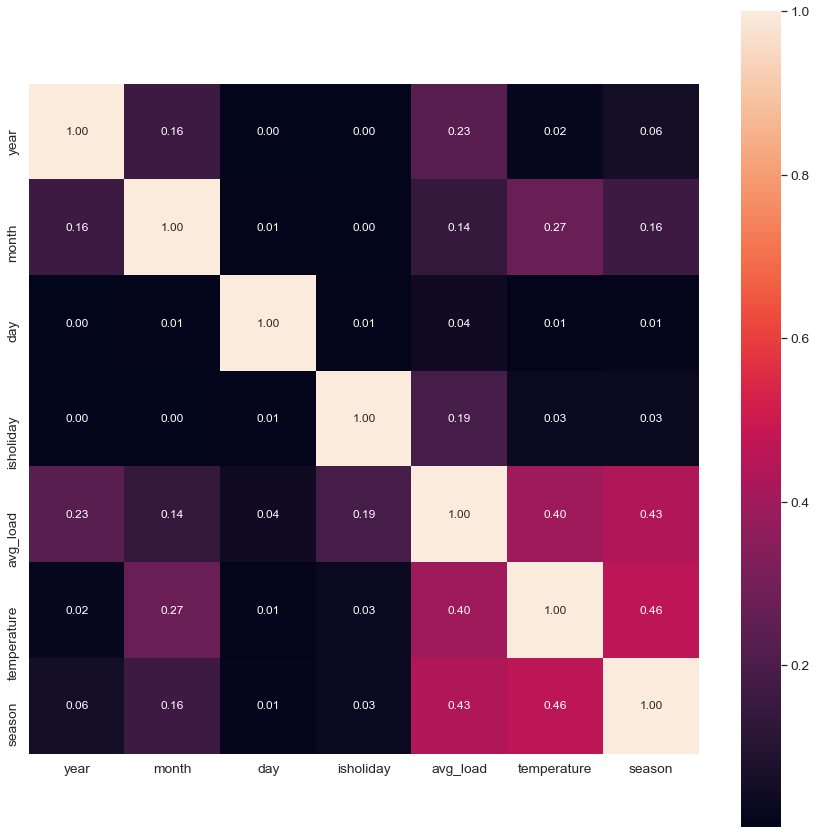

In [128]:
#Plotting of correlation matrix
k = 15 #number of variables for heatmap
corrmat = abs(clean_data[19].corr())
sns.set(font_scale=1.25)
# increase the default heatmap size
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, ax=ax)
plt.show()
#season is the most correlated feature to load 

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h16,h17,h18,h19,h20,h21,h22,h23,h24,avg_load
358,1,2004,12,24,"21,045","20,816","20,890","21,557","22,095","23,296",...,"24,686","25,669","26,762","26,721","26,914","27,313","27,476","27,511","26,916",25281.541667


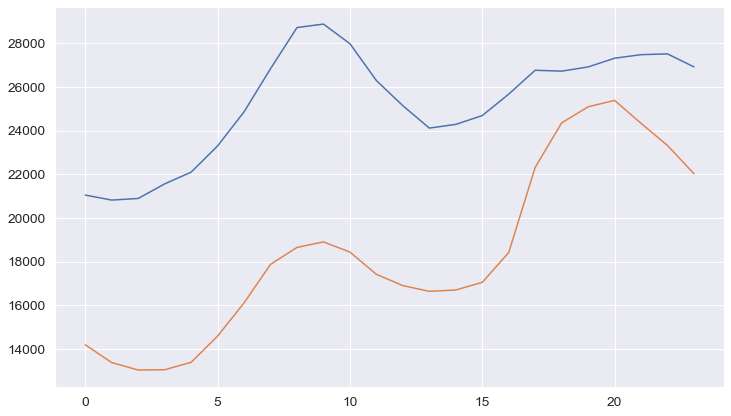

In [129]:
#2 day plot
y=extract_day_data_array(zones_data=zones,zone_id=1,year=2004,month=12,day=24)
x=extract_day_data_array(zones_data=zones,zone_id=1,year=2004,month=12,day=23)
plt.figure(figsize=(12,7))
plt.plot(y)
plt.plot(x)
day_data_df=extract_day_data_df(zones_data=zones,zone_id=1,year=2004,month=12,day=24)
day_data_df

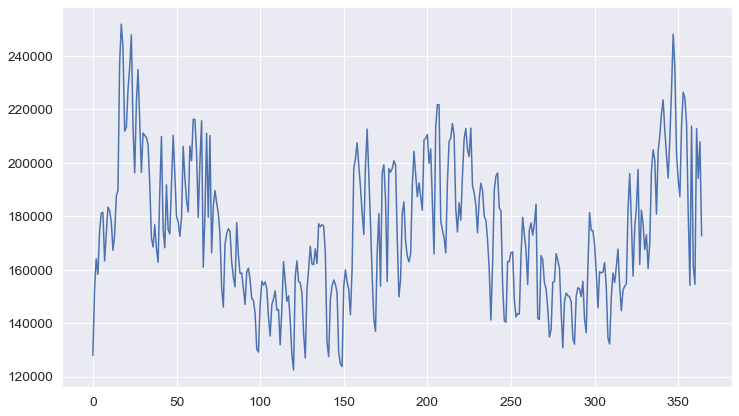

In [130]:
#1 year plot
plt.figure(figsize=(12,7))
plt.plot(replace_nan_year(zones,2,2005))

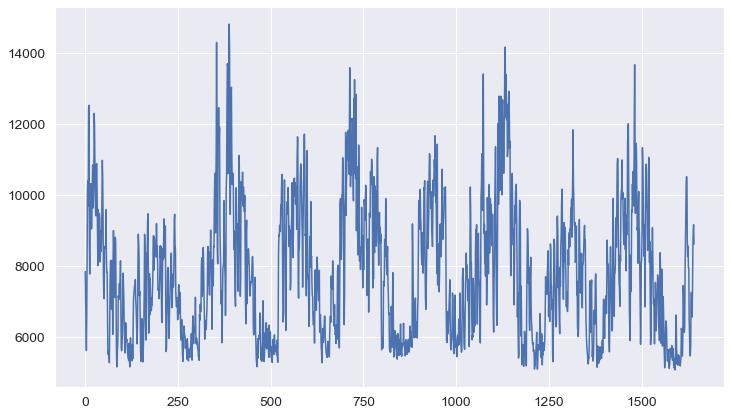

In [131]:
# plot for all available data
y = clean_zone_data(zones,5)
plt.figure(figsize=(12,7))
plt.plot(y)

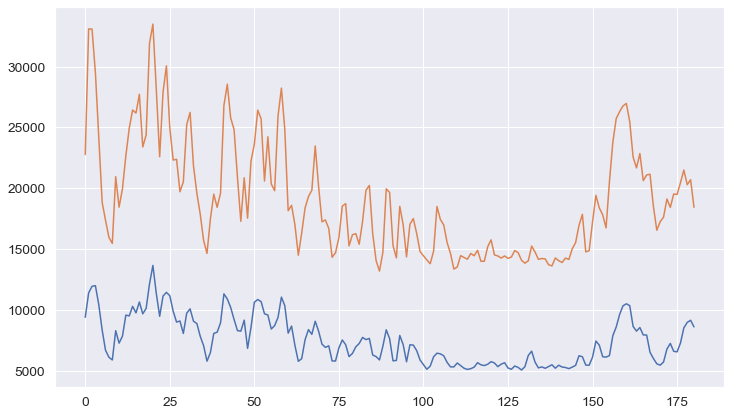

In [132]:
#Comparison of load data for 2 different zones
y = extract_year_data_array(zones_data=zones,zone_id=5,year=2008)
x = extract_year_data_array(zones_data=zones,zone_id=1,year=2008)
plt.figure(figsize=(12,7))
plt.plot(y)
plt.plot(x)

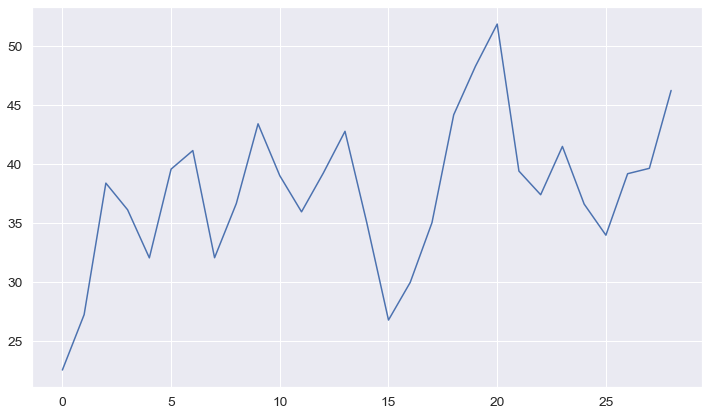

In [133]:
#1 month plot
y = month_total_avg_temp(stations,2004,2)
plt.figure(figsize=(12,7))
plt.plot(y)

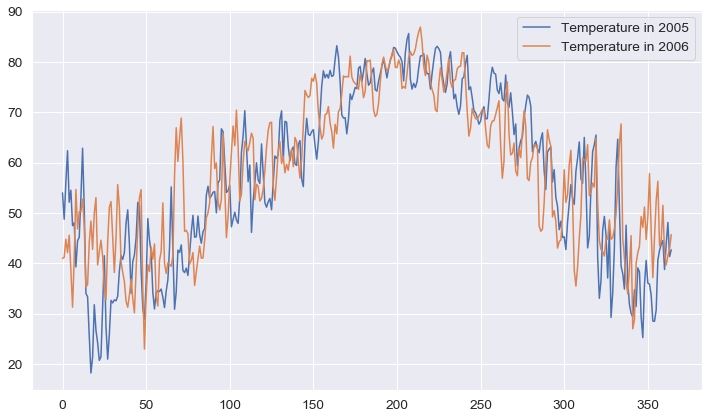

In [166]:
#2 year plot for the same zone data
y =  year_total_avg_temp(stations_data=stations,year=2005)
x =  year_total_avg_temp(stations_data=stations,year=2006)
plt.figure(figsize=(12,7))
plt.plot(y,label='Temperature in 2005')
plt.plot(x,label='Temperature in 2006')
plt.legend()
plt.show()

# 4. Preprocessing and Model training
We used random forest model as it is relevant to our problem and reliable and there is no increasing or decreasing trend as shown in the figure of all the data.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


# 4.1 Unoptimized model with Zone 1

In [136]:
zone1_data = clean_data[0]

In [137]:
y=zone1_data['avg_load']
X=zone1_data.drop('avg_load', axis=1)

In [138]:
tss = TimeSeriesSplit(n_splits = 10)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [139]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
clf_RF = RandomForestRegressor(max_depth=30)
clf_RF.fit(X_train,y_train)
y_pred = clf_RF.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [141]:
print("r2_score:",metrics.r2_score(y_test, y_pred))

r2_score: 0.7844858501662789


In [142]:
print("r2_score:",metrics.r2_score(y_test[0:10], y_pred[0:10]))

r2_score: 0.8561068948179544


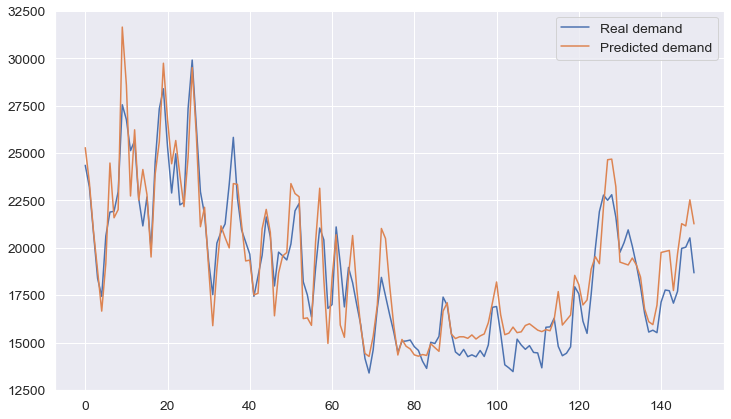

In [165]:
plt.figure(figsize=(12,7))
plt.plot(list(y_test),label='Real demand')
plt.plot(list(y_pred),label='Predicted demand')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

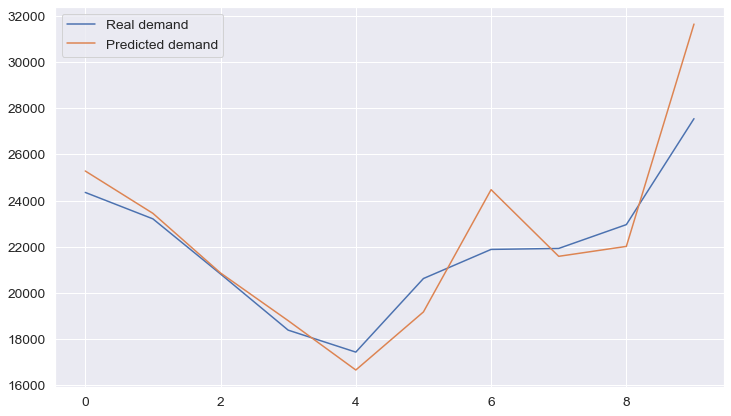

In [164]:
#10 days zoom in
fig = plt.figure()
plt.figure(figsize=(12,7))
plt.plot(list(y_test[0:10]),label='Real demand')
plt.plot(list(y_pred[0:10]),label='Predicted demand')
plt.legend()
plt.show()

In [145]:
dif=np.add(y_test[:10],-1*y_pred[:10])
max(dif)

451.32083333333503

# 4.2 Model Optimization and Training
%speak about optimization parameters

In [146]:
def randforest_optimizer(hyper_params,clean_data,n_splits_=10):
  y=clean_data['avg_load']
  X=clean_data.drop('avg_load', axis=1)
  
  tss = TimeSeriesSplit(n_splits = n_splits_)
  for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  
  clf_RF = RandomForestRegressor()
  
  cv=TimeSeriesSplit(n_splits=n_splits_)
  
  optimize = GridSearchCV(clf_RF,param_grid=hyper_params,scoring="r2",cv=cv,n_jobs=-1)
  optimize.fit(X_train,y_train)
  best_params=optimize.best_params_
  best_score = optimize.best_score_
  
  clf_RF_optimal = RandomForestRegressor(max_depth=best_params["max_depth"],n_estimators=best_params["n_estimators"])
  clf_RF_optimal.fit(X_train,y_train)
  y_pred = clf_RF_optimal.predict(X_test)
  score_test = metrics.r2_score(y_test, y_pred)
  
  return y_pred, y_test, score_test, best_score, best_params

# 4.3 Prediction for single zone

In [147]:
hyper_params={"max_depth":range(10,50),"n_estimators":range(15,20)}
y_pred, y_test, score_test, best_score, best_params = randforest_optimizer(hyper_params,clean_data[12],n_splits_=10)

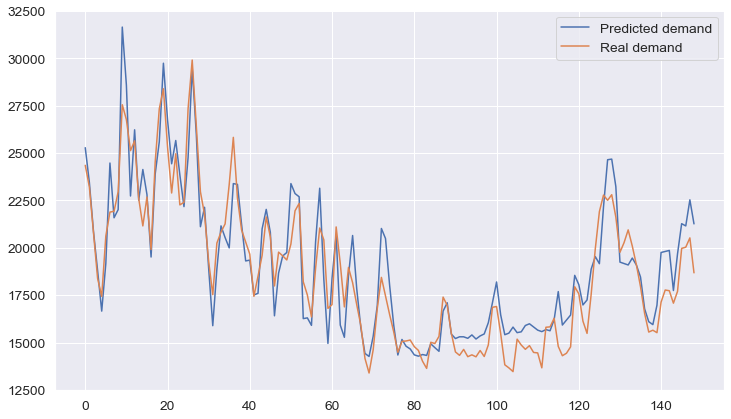

In [168]:
plt.figure(figsize=(12,7))
plt.plot(list(y_pred),label='Predicted demand')
plt.plot(list(y_test),label='Real demand')
plt.legend()
plt.show()


In [149]:
from math import sqrt
sqrt(metrics.mean_squared_error(y_pred,y_test))

1401.257744767408

In [150]:
sqrt(metrics.mean_squared_error(y_pred[:7],y_test[:7]))

1224.2387297276496

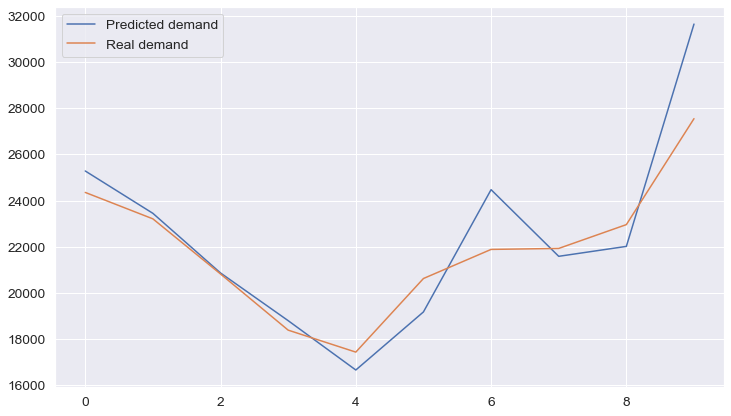

In [169]:
plt.figure(figsize=(12,7))
plt.plot(list(y_pred[:10]),label='Predicted demand')
plt.plot(list(y_test[:10]),label='Real demand')
plt.legend()
plt.show()


In [152]:
print(score_test)

0.8592446480692065


Text(0, 0.5, 'y_pred')

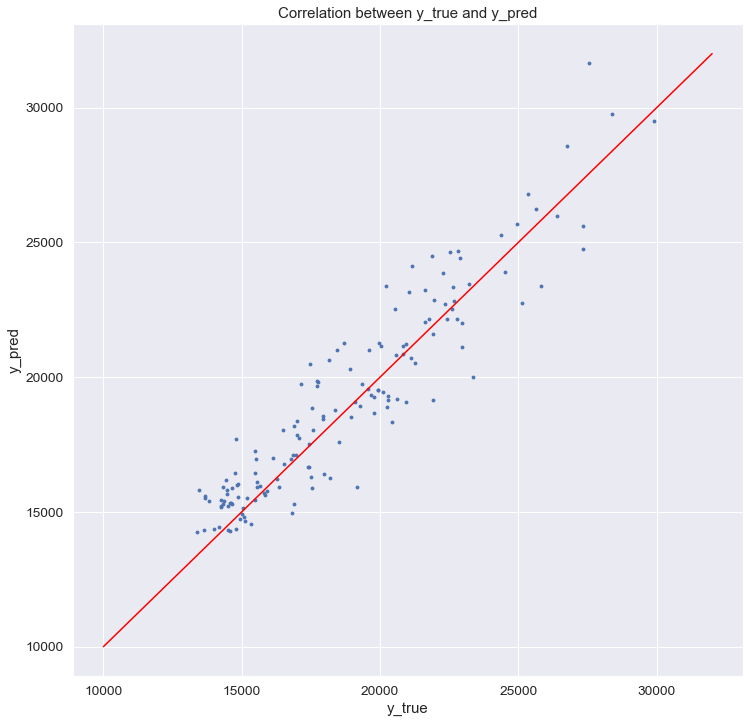

In [170]:
plt.figure(figsize=(12,12))
plt.plot(range(10000,32000),range(10000,32000),c='red')
plt.scatter(x=y_test, y=y_pred,s=8)
plt.title('Correlation between y_true and y_pred')
plt.xlabel('y_true')
plt.ylabel('y_pred')

# 4.4 Prediction for the whole system

In [171]:
import operator

system_data=clean_data[0]
for i in range(1,20):
  system_data['avg_load']=list(map(operator.add,list(system_data['avg_load']),list(clean_data[i]['avg_load'])))

In [173]:

system_data.head()

,year,month,day,isholiday,avg_load,temperature,season
0,2004,1,1,1,1.448289e+06,43.174242,1.0
1,2004,1,2,0,1.493542e+06,47.651515,1.0
2,2004,1,3,1,1.334606e+06,56.931818,1.0
3,2004,1,4,1,1.234683e+06,62.712121,1.0
4,2004,1,5,0,1.473262e+06,55.833333,1.0


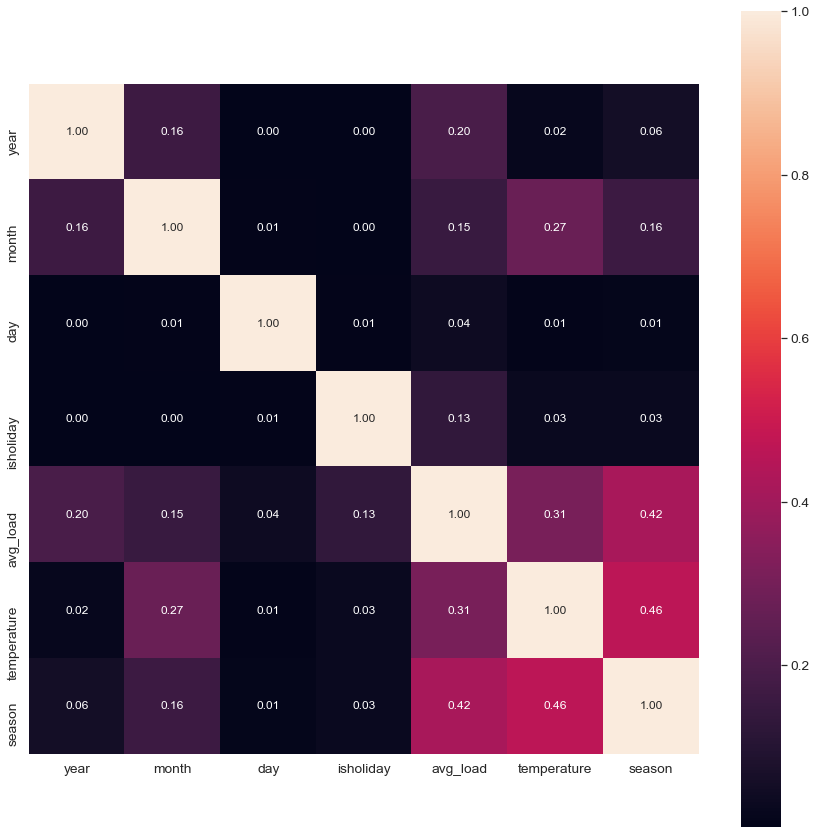

In [174]:
#Plotting of correlation matrix
k = 15 #number of variables for heatmap
corrmat = abs(system_data.corr())
sns.set(font_scale=1.25)
# increase the default heatmap size
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, ax=ax)
plt.show()

In [175]:
hyper_params_system={"max_depth":range(10,50),"n_estimators":range(15,20)}
y_pred_system, y_test_system, score_test_system, best_score_system, best_params_system = randforest_optimizer(hyper_params_system,system_data,n_splits_=10)

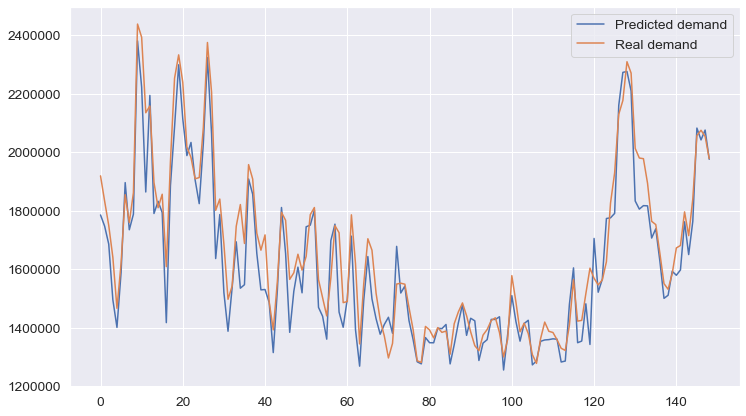

In [177]:
plt.figure(figsize=(12,7))
plt.plot(list(y_pred_system),label='Predicted demand')
plt.plot(list(y_test_system),label='Real demand')
plt.legend()
plt.show()

In [178]:
sqrt(metrics.mean_squared_error(y_pred_system,y_test_system))

91240.23917158289

In [179]:
print(score_test_system)

0.8925590981269858


In [180]:
sqrt(metrics.mean_squared_error(y_pred_system[:7],y_test_system[:7]))

90397.54089373758

Text(0, 0.5, 'y_pred')

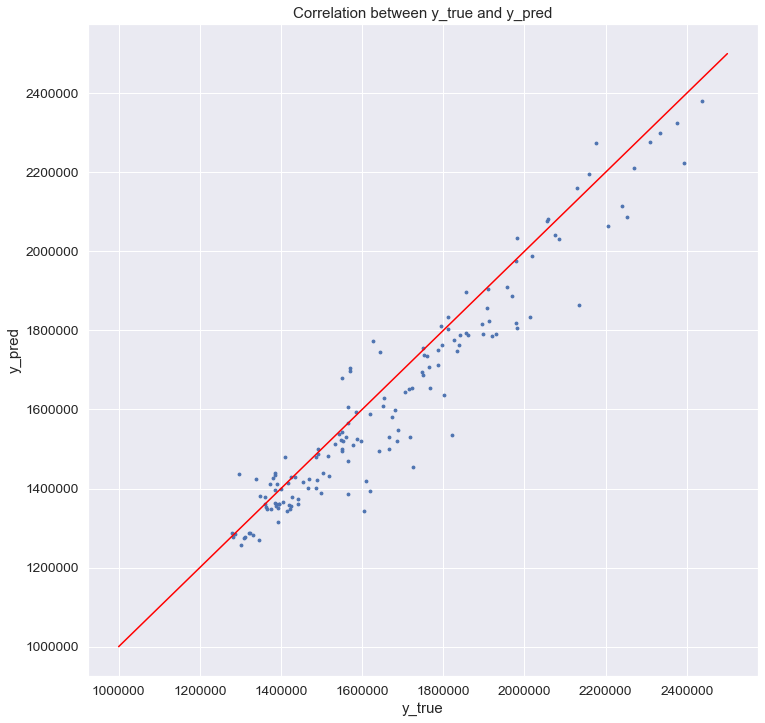

In [181]:
plt.figure(figsize=(12,12))
plt.plot(range(1000000,2500000),range(1000000,2500000),c='red')
plt.scatter(x=y_test_system, y=y_pred_system,s=8)
plt.title('Correlation between y_true and y_pred')
plt.xlabel('y_true')
plt.ylabel('y_pred')